Introduction:

This notebook is for tokenizing the time series data to tree. And the separation condtition will be the tree length with is the length(maximum-minimum) of all branches(bar) of the tree. 

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [97]:
# Load the data
data = pd.read_csv('/Users/eeevashen/Desktop/Apple_stock_data_6M.csv',low_memory=False)
# take out the Date column and Close/Last column
data = data[['Date','Close/Last']]
# make the whole dataframe upside down
data = data[::-1]
# seperate the Date column by month
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month

In [98]:
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
# make the Close/Last column as float
data['Close/Last'] = data['Close/Last'].str.replace('$','').astype(float)
# make the Date column and Close/Last column as a tuple
tuple_data = list(zip(data['Date'],data['Close/Last']))

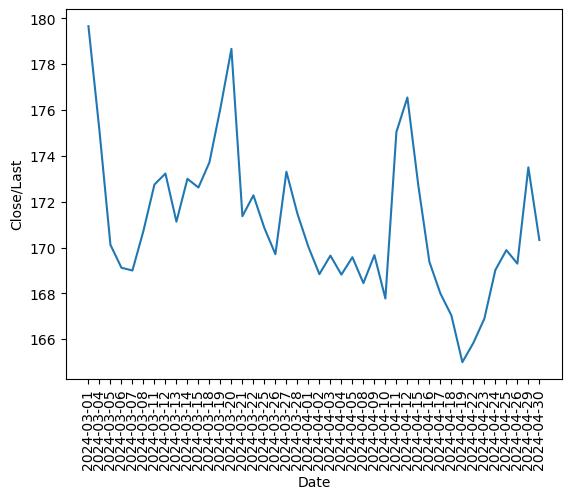

In [99]:
# pick month=4 5 6 data to plot
data = data[data['Month'].isin([3,4])]
# data = data[data['Month']==4]
# plot the data
plt.plot(data['Date'],data['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last')
# make the x-axis label lilted
plt.xticks(rotation=90)
plt.show()

In [100]:
time_series = (data['Close/Last'].tolist(), data['Date'].tolist())

In [101]:
def modify(original_time_series, bar_lists, difference=0):
  indices_to_be_updated_list = []
  values_to_be_updated_list = []
  for bar_list in bar_lists:
    start_idx = bar_list[0][0]
    start_val = bar_list[0][1]
    end_idx = bar_list[1][0]
    end_val = bar_list[1][1]
    if start_val - end_val > difference: # check bar display(right)
      continue
    # ---
    #  |
    #  |
    if start_idx < end_idx:
      indices_to_be_updated = []
      for i in range(start_idx+1, len(original_time_series)):
        if original_time_series[i] <= start_val:
          indices_to_be_updated.append(i)
        else:
          break
      values_to_be_updated = start_val
    # ---
    # |
    # |
    else:                                # check bar display(left)
      indices_to_be_updated = []
      for i in reversed(range(0, start_idx)):
        if original_time_series[i] <= start_val:
          indices_to_be_updated.append(i)
        else:
          break
      values_to_be_updated = start_val
    indices_to_be_updated_list.append(indices_to_be_updated)
    values_to_be_updated_list.append(values_to_be_updated)
  print(indices_to_be_updated_list)
  print(values_to_be_updated_list)
  return indices_to_be_updated_list, values_to_be_updated_list


def get_result(time_series, indices_to_be_updated_list, values_to_be_updated_list):
  result = time_series.copy()
  for indices_to_be_updated, values_to_be_updated in zip(indices_to_be_updated_list, values_to_be_updated_list):
    for idx in indices_to_be_updated:
      result[idx] = max(result[idx], values_to_be_updated)
  return result

def get_result_remove(time_series, date_series, indices_to_be_updated_list, values_to_be_updated_list):
  for indices_to_be_updated, values_to_be_updated in zip(indices_to_be_updated_list, values_to_be_updated_list):
    for idx in indices_to_be_updated:
      time_series = time_series.pop(idx)
      date_series = date_series.pop(idx)
  return time_series, date_series

In [102]:
def one_pass_bar_algorithm(time_series, date_list=None, print_bars=True):
    bar_list = []
    maxima, minima = [], []
    direction = 1

    # add a very small point at the front of the time_series
    time_series = [time_series[0] - 1e-6] + time_series
    # add a very big point at the end of the time_series
    time_series = time_series + [time_series[-1] + 1e-6]

    for t in range(0, len(time_series)-1):
        if (time_series[t+1] - time_series[t]) * direction < 0:
            if direction == 1:
                if len(maxima) != 0 and time_series[t] > maxima[-1][1]:
                    output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
                maxima.append((t, time_series[t])) 
            else:
                if len(minima) != 0 and time_series[t] < minima[-1][1]:
                    output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
                minima.append((t, time_series[t]))
            direction = -direction
        else:
          if direction == 1 and len(maxima) != 0 and time_series[t] > maxima[-1][1]:
              output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
          elif direction == -1 and len(minima) != 0 and time_series[t] < minima[-1][1]:
              output_bar(maxima.pop(), minima.pop(),date_list, bar_list, print_bars)
    output_remaining_bars(maxima, minima, date_list, bar_list, print_bars)
    return bar_list

def output_bar(max_value, min_value, date_list, bar_list, print_bars):
    if date_list is None:
        length = max_value[1] - min_value[1]
        if print_bars == True:
            print(f"(normal)Bar: ({max_value[0]}, {max_value[1]}) to ({min_value[0]}, {min_value[1]}), length: {length}")
        bar_list.append(((max_value[0], max_value[1]), (min_value[0], min_value[1]), length))

    else:
        length = max_value[1] - min_value[1]
        if print_bars == True:
            print(f"(normal)Bar: ({date_list[max_value[0]-1]}, {max_value[1]}) to ({date_list[min_value[0]-1]}, {min_value[1]}), length: {length}")
        bar_list.append(((date_list[max_value[0]-1], max_value[1]), (date_list[min_value[0]-1], min_value[1]), length))

def output_remaining_bars(maxima, minima, date_list, bar_list, print_bars):
    if date_list is None:
        for i in range(min(len(maxima), len(minima))):
            length = maxima[i][1] - minima[i][1]
            if print_bars == True:
                print(f"(remaining)Bar: ({maxima[i][0]}, {maxima[i][1]}) to ({minima[i][0]}, {minima[i][1]}), length: {length}")
            bar_list.append(((maxima[i][0], maxima[i][1]),  (minima[i][0], minima[i][1]), length))

    else:
        for i in range(min(len(maxima), len(minima))):
            length = maxima[i][1] - minima[i][1]
            if print_bars == True:
                print(f"(remaining)Bar: ({date_list[maxima[i][0]-1]}, {maxima[i][1]}) to ({date_list[minima[i][0]-1]}, {minima[i][1]}), length: {length}")
            bar_list.append(((date_list[maxima[i][0]-1], maxima[i][1]), (date_list[minima[i][0]-1], minima[i][1]), length))


In [103]:
(value, date) = time_series
one_pass_bar_algorithm(value, date)

(normal)Bar: (2024-03-14, 173.0) to (2024-03-15, 172.62), length: 0.37999999999999545
(normal)Bar: (2024-03-12, 173.23) to (2024-03-13, 171.13), length: 2.0999999999999943
(normal)Bar: (2024-03-22, 172.28) to (2024-03-21, 171.37), length: 0.9099999999999966
(normal)Bar: (2024-03-27, 173.31) to (2024-03-26, 169.71), length: 3.5999999999999943
(normal)Bar: (2024-04-03, 169.65) to (2024-04-02, 168.84), length: 0.8100000000000023
(normal)Bar: (2024-04-05, 169.58) to (2024-04-04, 168.82), length: 0.7600000000000193
(normal)Bar: (2024-04-09, 169.67) to (2024-04-08, 168.45), length: 1.2199999999999989
(normal)Bar: (2024-04-12, 176.55) to (2024-04-10, 167.78), length: 8.77000000000001
(normal)Bar: (2024-03-20, 178.67) to (2024-03-07, 169.0), length: 9.669999999999987
(normal)Bar: (2024-04-25, 169.89) to (2024-04-26, 169.3), length: 0.589999999999975
(remaining)Bar: (2024-03-01, 179.66) to (2024-04-19, 165.0), length: 14.659999999999997
(remaining)Bar: (2024-04-29, 173.5) to (2024-04-30, 170.33

[(('2024-03-14', 173.0), ('2024-03-15', 172.62), 0.37999999999999545),
 (('2024-03-12', 173.23), ('2024-03-13', 171.13), 2.0999999999999943),
 (('2024-03-22', 172.28), ('2024-03-21', 171.37), 0.9099999999999966),
 (('2024-03-27', 173.31), ('2024-03-26', 169.71), 3.5999999999999943),
 (('2024-04-03', 169.65), ('2024-04-02', 168.84), 0.8100000000000023),
 (('2024-04-05', 169.58), ('2024-04-04', 168.82), 0.7600000000000193),
 (('2024-04-09', 169.67), ('2024-04-08', 168.45), 1.2199999999999989),
 (('2024-04-12', 176.55), ('2024-04-10', 167.78), 8.77000000000001),
 (('2024-03-20', 178.67), ('2024-03-07', 169.0), 9.669999999999987),
 (('2024-04-25', 169.89), ('2024-04-26', 169.3), 0.589999999999975),
 (('2024-03-01', 179.66), ('2024-04-19', 165.0), 14.659999999999997),
 (('2024-04-29', 173.5), ('2024-04-30', 170.33), 3.1699999999999875)]

In [104]:
bar_list = one_pass_bar_algorithm(value, date)
# sort the bar_list by the end date

(normal)Bar: (2024-03-14, 173.0) to (2024-03-15, 172.62), length: 0.37999999999999545
(normal)Bar: (2024-03-12, 173.23) to (2024-03-13, 171.13), length: 2.0999999999999943
(normal)Bar: (2024-03-22, 172.28) to (2024-03-21, 171.37), length: 0.9099999999999966
(normal)Bar: (2024-03-27, 173.31) to (2024-03-26, 169.71), length: 3.5999999999999943
(normal)Bar: (2024-04-03, 169.65) to (2024-04-02, 168.84), length: 0.8100000000000023
(normal)Bar: (2024-04-05, 169.58) to (2024-04-04, 168.82), length: 0.7600000000000193
(normal)Bar: (2024-04-09, 169.67) to (2024-04-08, 168.45), length: 1.2199999999999989
(normal)Bar: (2024-04-12, 176.55) to (2024-04-10, 167.78), length: 8.77000000000001
(normal)Bar: (2024-03-20, 178.67) to (2024-03-07, 169.0), length: 9.669999999999987
(normal)Bar: (2024-04-25, 169.89) to (2024-04-26, 169.3), length: 0.589999999999975
(remaining)Bar: (2024-03-01, 179.66) to (2024-04-19, 165.0), length: 14.659999999999997
(remaining)Bar: (2024-04-29, 173.5) to (2024-04-30, 170.33

In [105]:
print(type(time_series[0][0]))
print(bar_list)

<class 'float'>
[(('2024-03-14', 173.0), ('2024-03-15', 172.62), 0.37999999999999545), (('2024-03-12', 173.23), ('2024-03-13', 171.13), 2.0999999999999943), (('2024-03-22', 172.28), ('2024-03-21', 171.37), 0.9099999999999966), (('2024-03-27', 173.31), ('2024-03-26', 169.71), 3.5999999999999943), (('2024-04-03', 169.65), ('2024-04-02', 168.84), 0.8100000000000023), (('2024-04-05', 169.58), ('2024-04-04', 168.82), 0.7600000000000193), (('2024-04-09', 169.67), ('2024-04-08', 168.45), 1.2199999999999989), (('2024-04-12', 176.55), ('2024-04-10', 167.78), 8.77000000000001), (('2024-03-20', 178.67), ('2024-03-07', 169.0), 9.669999999999987), (('2024-04-25', 169.89), ('2024-04-26', 169.3), 0.589999999999975), (('2024-03-01', 179.66), ('2024-04-19', 165.0), 14.659999999999997), (('2024-04-29', 173.5), ('2024-04-30', 170.33), 3.1699999999999875)]


(normal)Bar: (10, 173.0) to (11, 172.62), length: 0.37999999999999545
(normal)Bar: (8, 173.23) to (9, 171.13), length: 2.0999999999999943
(normal)Bar: (16, 172.28) to (15, 171.37), length: 0.9099999999999966
(normal)Bar: (19, 173.31) to (18, 169.71), length: 3.5999999999999943
(normal)Bar: (23, 169.65) to (22, 168.84), length: 0.8100000000000023
(normal)Bar: (25, 169.58) to (24, 168.82), length: 0.7600000000000193
(normal)Bar: (27, 169.67) to (26, 168.45), length: 1.2199999999999989
(normal)Bar: (30, 176.55) to (28, 167.78), length: 8.77000000000001
(normal)Bar: (14, 178.67) to (5, 169.0), length: 9.669999999999987
(normal)Bar: (39, 169.89) to (40, 169.3), length: 0.589999999999975
(remaining)Bar: (1, 179.66) to (35, 165.0), length: 14.659999999999997
(remaining)Bar: (41, 173.5) to (42, 170.33), length: 3.1699999999999875
[[], [9, 10], [15, 14], [22, 21], [24, 23], [26, 25, 24, 23, 22, 21], []]
[173.0, 173.23, 172.28, 169.65, 169.58, 169.67, 169.89]


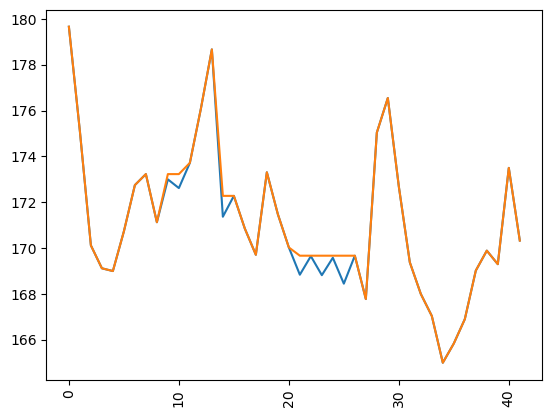

In [106]:
# time_series = [0, 11, 9, 4, 3, 5, 8, 6, 1, 2, 7, 10, 12]
time_series_removeing = data['Close/Last'].tolist()
bar_list_removing = one_pass_bar_algorithm(time_series_removeing)
indices_to_be_updated_list, values_to_be_updated_list = modify(time_series_removeing, bar_list_removing, difference = 3)
updated_time_series = get_result(time_series_removeing, indices_to_be_updated_list, values_to_be_updated_list)
plt.figure()
plt.plot(time_series_removeing)
plt.plot(updated_time_series)
plt.xticks(rotation=90)
plt.show()

In [107]:
time_series_cleaned = (updated_time_series, date)


if we need to keep the bars from the raw data, as we can't cut the bar in the middle, we have to decide a proper length as our threshold and the threshold should be a range
then the tokenized trees will be in different length but could in a small range

we define tree length as the summation of (max-min) of each bar of a tree

In [108]:
def separate_series_by_length(time_series, length = 10):
    length_tmp = 0
    tree_set = []
    value_tmp = []
    date_tmp = []
    bar_set = []
    for value, date in zip(*time_series):
        value_tmp.append(value)
        date_tmp.append(date)
        # print(value, date)
        # print(type(value), type(date))
        bar_list = one_pass_bar_algorithm(value_tmp, date_tmp, False)
        length_tmp = 0
        for bar in bar_list:
            # print(bar)
            length_tmp += bar[2]
            bar_set.append(bar)
            if length_tmp > length:
                tree_set.append(((value_tmp, date_tmp), length_tmp))
                value_tmp = []
                date_tmp = []
                length_tmp = 0
                break
            # else:
            #     length_tmp += bar[2]
    return tree_set # return a list of tuple, each tuple contains a tuple of time_series and a length, which is the tree structure here


# use the tree_set to find the bar set for each tree's date period
def find_valid_bar(tree_set):
    bar_set = []
    for tree in tree_set:
        time_series = tree[0]
        length = tree[1]
        bar_list = one_pass_bar_algorithm(time_series[0], time_series[1], False)
        bar_set.append(bar_list)
    return bar_set


In [109]:
separate_series_by_length(time_series_cleaned)

[(([179.66, 175.1, 170.12, 169.12],
   ['2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06']),
  10.539999999999992),
 (([169.0,
    170.73,
    172.75,
    173.23,
    171.13,
    173.23,
    173.23,
    173.72,
    176.08,
    178.67,
    172.28,
    172.28,
    170.85,
    169.71],
   ['2024-03-07',
    '2024-03-08',
    '2024-03-11',
    '2024-03-12',
    '2024-03-13',
    '2024-03-14',
    '2024-03-15',
    '2024-03-18',
    '2024-03-19',
    '2024-03-20',
    '2024-03-21',
    '2024-03-22',
    '2024-03-25',
    '2024-03-26']),
  11.059999999999974),
 (([173.31,
    171.48,
    170.03,
    169.67,
    169.67,
    169.67,
    169.67,
    169.67,
    169.67,
    167.78,
    175.04,
    176.55,
    172.69,
    169.38],
   ['2024-03-27',
    '2024-03-28',
    '2024-04-01',
    '2024-04-02',
    '2024-04-03',
    '2024-04-04',
    '2024-04-05',
    '2024-04-08',
    '2024-04-09',
    '2024-04-10',
    '2024-04-11',
    '2024-04-12',
    '2024-04-15',
    '2024-04-16']),
  12.700000

In [110]:
print(time_series_cleaned)

([179.66, 175.1, 170.12, 169.12, 169.0, 170.73, 172.75, 173.23, 171.13, 173.23, 173.23, 173.72, 176.08, 178.67, 172.28, 172.28, 170.85, 169.71, 173.31, 171.48, 170.03, 169.67, 169.67, 169.67, 169.67, 169.67, 169.67, 167.78, 175.04, 176.55, 172.69, 169.38, 168.0, 167.04, 165.0, 165.84, 166.9, 169.02, 169.89, 169.3, 173.5, 170.33], ['2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-29', '2024-04-30'])


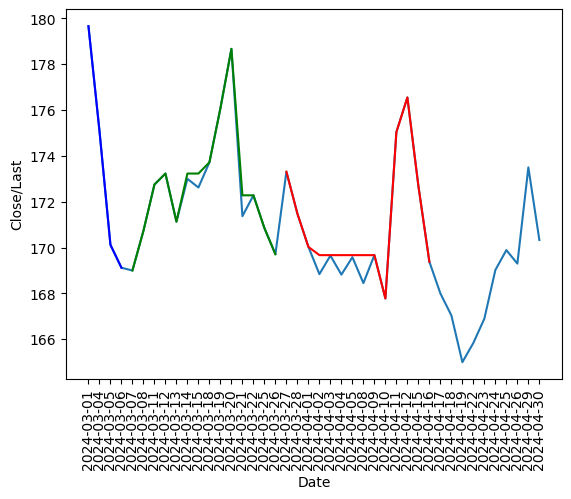

In [111]:
tree_set = separate_series_by_length(time_series_cleaned)
#plot the bar_set on the graph using different colors for different bars
data = data[data['Month'].isin([3,4])]
# data = data[data['Month']==4]
# plot the data
plt.plot(data['Date'],data['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last')
# make the x-axis label lilted
plt.xticks(rotation=90)

color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i, bar in enumerate(tree_set):
    value, date = bar[0]
    plt.plot(date, value, color=color[i%8])
plt.show()





In [112]:
bar_set_for_tree = find_valid_bar(tree_set)
print(bar_set_for_tree)

[[(('2024-03-01', 179.66), ('2024-03-06', 169.12), 10.539999999999992)], [(('2024-03-12', 173.23), ('2024-03-13', 171.13), 2.0999999999999943), (('2024-03-20', 178.67), ('2024-03-26', 169.71), 8.95999999999998)], [(('2024-03-27', 173.31), ('2024-04-10', 167.78), 5.530000000000001), (('2024-04-12', 176.55), ('2024-04-16', 169.38), 7.170000000000016)]]


We can test this algorithm on larger data.

In [113]:
# Load the data
data = pd.read_csv('/Users/eeevashen/Desktop/Apple_stock_data_6M.csv',low_memory=False)
# take out the Date column and Close/Last column
data = data[['Date','Close/Last']]
# make the whole dataframe upside down
data = data[::-1]
# seperate the Date column by month
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month

In [114]:
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
# make the Close/Last column as float
data['Close/Last'] = data['Close/Last'].str.replace('$','').astype(float)
# make the Date column and Close/Last column as a tuple
tuple_data = list(zip(data['Date'],data['Close/Last']))

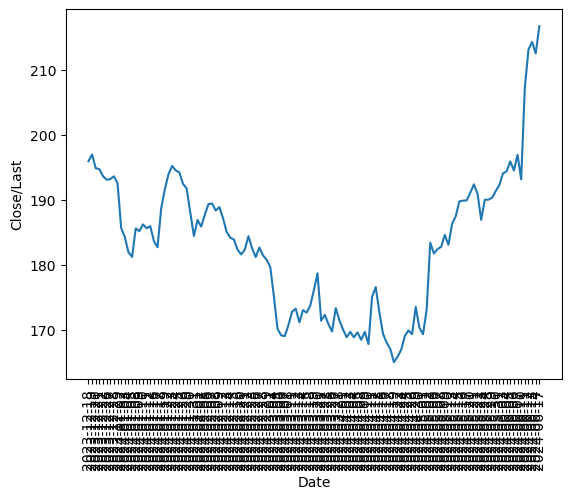

In [115]:
# plot the data
plt.plot(data['Date'],data['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last')
# make the x-axis label lilted
plt.xticks(rotation=90)
plt.show()

In [116]:
time_series = (data['Close/Last'].tolist(), data['Date'].tolist())

In [117]:
print(len(time_series[1]))

125


In [118]:
(value, date) = time_series
one_pass_bar_algorithm(value, date)

(normal)Bar: (2023-12-28, 193.58) to (2023-12-26, 193.05), length: 0.5300000000000011
(normal)Bar: (2024-01-08, 185.56) to (2024-01-09, 185.14), length: 0.4200000000000159
(normal)Bar: (2024-01-12, 185.92) to (2024-01-11, 185.59), length: 0.3299999999999841
(normal)Bar: (2024-01-10, 186.19) to (2024-01-17, 182.68), length: 3.509999999999991
(normal)Bar: (2024-02-01, 186.86) to (2024-02-02, 185.85), length: 1.0100000000000193
(normal)Bar: (2024-02-09, 188.85) to (2024-02-08, 188.32), length: 0.5300000000000011
(normal)Bar: (2024-02-07, 189.41) to (2024-01-31, 184.4), length: 5.009999999999991
(normal)Bar: (2024-02-22, 184.37) to (2024-02-20, 181.56), length: 2.8100000000000023
(normal)Bar: (2024-02-27, 182.63) to (2024-02-26, 181.16), length: 1.4699999999999989
(normal)Bar: (2024-01-23, 195.18) to (2024-01-05, 181.18), length: 14.0
(normal)Bar: (2024-03-14, 173.0) to (2024-03-15, 172.62), length: 0.37999999999999545
(normal)Bar: (2024-03-12, 173.23) to (2024-03-13, 171.13), length: 2.09

[(('2023-12-28', 193.58), ('2023-12-26', 193.05), 0.5300000000000011),
 (('2024-01-08', 185.56), ('2024-01-09', 185.14), 0.4200000000000159),
 (('2024-01-12', 185.92), ('2024-01-11', 185.59), 0.3299999999999841),
 (('2024-01-10', 186.19), ('2024-01-17', 182.68), 3.509999999999991),
 (('2024-02-01', 186.86), ('2024-02-02', 185.85), 1.0100000000000193),
 (('2024-02-09', 188.85), ('2024-02-08', 188.32), 0.5300000000000011),
 (('2024-02-07', 189.41), ('2024-01-31', 184.4), 5.009999999999991),
 (('2024-02-22', 184.37), ('2024-02-20', 181.56), 2.8100000000000023),
 (('2024-02-27', 182.63), ('2024-02-26', 181.16), 1.4699999999999989),
 (('2024-01-23', 195.18), ('2024-01-05', 181.18), 14.0),
 (('2024-03-14', 173.0), ('2024-03-15', 172.62), 0.37999999999999545),
 (('2024-03-12', 173.23), ('2024-03-13', 171.13), 2.0999999999999943),
 (('2024-03-22', 172.28), ('2024-03-21', 171.37), 0.9099999999999966),
 (('2024-03-27', 173.31), ('2024-03-26', 169.71), 3.5999999999999943),
 (('2024-04-03', 169.65

(normal)Bar: (8, 193.58) to (6, 193.05), length: 0.5300000000000011
(normal)Bar: (14, 185.56) to (15, 185.14), length: 0.4200000000000159
(normal)Bar: (18, 185.92) to (17, 185.59), length: 0.3299999999999841
(normal)Bar: (16, 186.19) to (20, 182.68), length: 3.509999999999991
(normal)Bar: (31, 186.86) to (32, 185.85), length: 1.0100000000000193
(normal)Bar: (37, 188.85) to (36, 188.32), length: 0.5300000000000011
(normal)Bar: (35, 189.41) to (30, 184.4), length: 5.009999999999991
(normal)Bar: (45, 184.37) to (43, 181.56), length: 2.8100000000000023
(normal)Bar: (48, 182.63) to (47, 181.16), length: 1.4699999999999989
(normal)Bar: (24, 195.18) to (13, 181.18), length: 14.0
(normal)Bar: (60, 173.0) to (61, 172.62), length: 0.37999999999999545
(normal)Bar: (58, 173.23) to (59, 171.13), length: 2.0999999999999943
(normal)Bar: (66, 172.28) to (65, 171.37), length: 0.9099999999999966
(normal)Bar: (69, 173.31) to (68, 169.71), length: 3.5999999999999943
(normal)Bar: (73, 169.65) to (72, 168.8

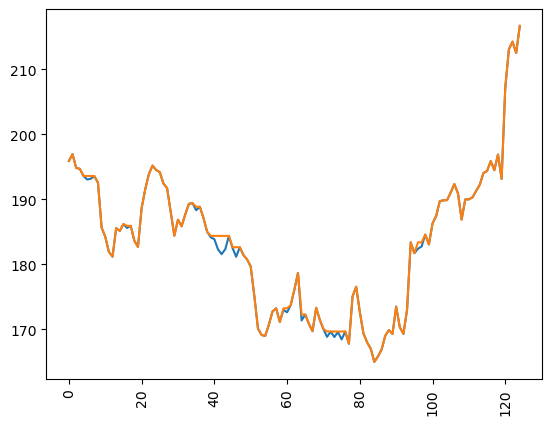

In [119]:
time_series_removeing = data['Close/Last'].tolist()
bar_list_removing = one_pass_bar_algorithm(time_series_removeing)
indices_to_be_updated_list, values_to_be_updated_list = modify(time_series_removeing, bar_list_removing, difference = 3)
updated_time_series = get_result(time_series_removeing, indices_to_be_updated_list, values_to_be_updated_list)
plt.figure()
plt.plot(time_series_removeing)
plt.plot(updated_time_series)
plt.xticks(rotation=90)
plt.show()

In [120]:
time_series_cleaned = (updated_time_series, date)

In [121]:
print(len(time_series_cleaned[0]))
print(len(time_series_cleaned[1]))

125
125


In [122]:
separate_series_by_length(time_series_cleaned)


[(([195.89,
    196.94,
    194.83,
    194.68,
    193.6,
    193.58,
    193.58,
    193.58,
    192.53,
    185.64],
   ['2023-12-18',
    '2023-12-19',
    '2023-12-20',
    '2023-12-21',
    '2023-12-22',
    '2023-12-26',
    '2023-12-27',
    '2023-12-28',
    '2023-12-29',
    '2024-01-02']),
  11.300000000000011),
 (([184.25,
    181.91,
    181.18,
    185.56,
    185.14,
    186.19,
    185.92,
    185.92,
    183.63,
    182.68,
    188.63,
    191.56,
    193.89,
    195.18,
    194.5,
    194.17,
    192.42,
    191.73],
   ['2024-01-03',
    '2024-01-04',
    '2024-01-05',
    '2024-01-08',
    '2024-01-09',
    '2024-01-10',
    '2024-01-11',
    '2024-01-12',
    '2024-01-16',
    '2024-01-17',
    '2024-01-18',
    '2024-01-19',
    '2024-01-22',
    '2024-01-23',
    '2024-01-24',
    '2024-01-25',
    '2024-01-26',
    '2024-01-29']),
  10.450000000000017),
 (([188.04,
    184.4,
    186.86,
    185.85,
    187.68,
    189.3,
    189.41,
    188.85,
    188.85,
    

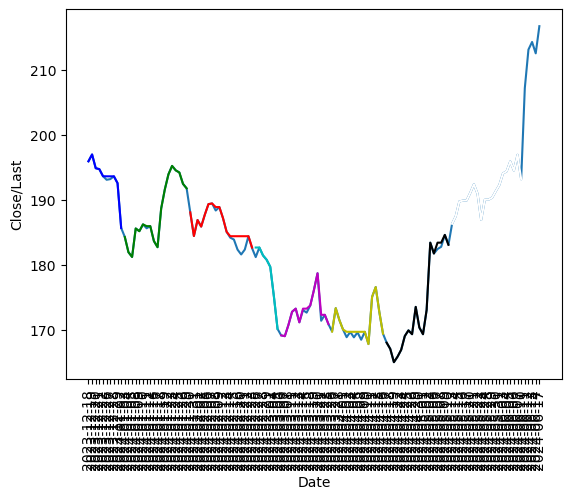

In [123]:
bar_set = separate_series_by_length(time_series_cleaned)
#plot the bar_set on the graph using different colors for different bars
# data = data[data['Month']==4]
# plot the data
plt.plot(data['Date'],data['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last')
# make the x-axis label lilted
plt.xticks(rotation=90)

color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i, bar in enumerate(bar_set):
    value, date = bar[0]
    plt.plot(date, value, color=color[i%8])
plt.show()





In [124]:
separate_series_by_length(time_series)

[(([195.89,
    196.94,
    194.83,
    194.68,
    193.6,
    193.05,
    193.15,
    193.58,
    192.53,
    185.64],
   ['2023-12-18',
    '2023-12-19',
    '2023-12-20',
    '2023-12-21',
    '2023-12-22',
    '2023-12-26',
    '2023-12-27',
    '2023-12-28',
    '2023-12-29',
    '2024-01-02']),
  11.830000000000013),
 (([184.25,
    181.91,
    181.18,
    185.56,
    185.14,
    186.19,
    185.59,
    185.92,
    183.63,
    182.68,
    188.63,
    191.56,
    193.89,
    195.18,
    194.5,
    194.17,
    192.42],
   ['2024-01-03',
    '2024-01-04',
    '2024-01-05',
    '2024-01-08',
    '2024-01-09',
    '2024-01-10',
    '2024-01-11',
    '2024-01-12',
    '2024-01-16',
    '2024-01-17',
    '2024-01-18',
    '2024-01-19',
    '2024-01-22',
    '2024-01-23',
    '2024-01-24',
    '2024-01-25',
    '2024-01-26']),
  10.090000000000003),
 (([191.73,
    188.04,
    184.4,
    186.86,
    185.85,
    187.68,
    189.3,
    189.41,
    188.32,
    188.85,
    187.15],
   ['2024